True
Class labels: ['infected', 'notinfected']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.7921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4164, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2641, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1964, device='cuda:0', grad_fn=

<ipython-input-2-b5d133e007ba>:264: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


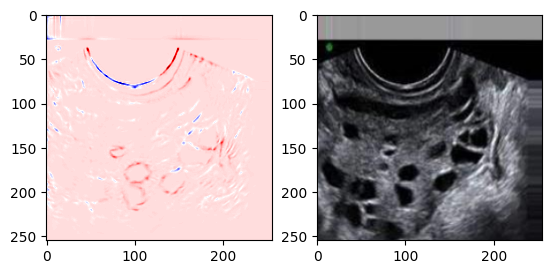

In [2]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd
# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda")


# %% Load data
TEST_ROOT = '/kaggle/input/pcos-detection-using-ultrasound-images/data/test'
TRAIN_ROOT = '/kaggle/input/pcos-detection-using-ultrasound-images/data/train'

# Modify the dataset paths to include subfolders
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT, transform=transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
]))

test_dataset = torchvision.datasets.ImageFolder(root=TEST_ROOT, transform=transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
]))

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer according to the number of classes
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, len(class_labels))

    def forward(self, x):
        x = self.vgg16(x)
        return x


# Modify the class labels based on subfolders
class_labels = train_dataset.classes
print("Class labels:", class_labels)

# Instantiate the model
model = CNNModel()



# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)
# Instantiate the model
model = CNNModel()

# Move the model to the GPU (if available)
model = model.to(device)
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 1
# Iterate x epochs over the train data
for epoch in range(epochs):
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss)

# %% Inspect predictions for first batch
import pandas as pd
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels
comparison["outputs"] = outputs

# %% Layerwise relevance propagation for VGG16
# For other CNN architectures this code might become more complex
# Source: https://git.tu-berlin.de/gmontavon/lrp-tutorial
# http://iphome.hhi.de/samek/pdf/MonXAI19.pdf

def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']):
        if isinstance(layer, nn.Linear):
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations

    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0
                        for val in output_activation[0]]

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward();
            c = activations[layer].grad
            # Assign new relevance values
            relevances[layer] = (activations[layer]*c).data
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]



# Example for adjusting the last layer in the model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer according to the number of classes
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x

# %%
# Calculate relevances for the first image in this test batch
image_id = 18
image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()),
                                                (0, 1))
# Show relevances
pred_label = list(test_dataset.class_to_idx.keys())[
             list(test_dataset.class_to_idx.values())
            .index(labels[image_id])]
if outputs[image_id] == labels[image_id]:
    print("Groundtruth for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(image_relevances[:,:,0], cmap="seismic")
    plt.subplot(1,2,2)
    plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
    plt.show()
else:
    print("This image is not classified correctly.")

